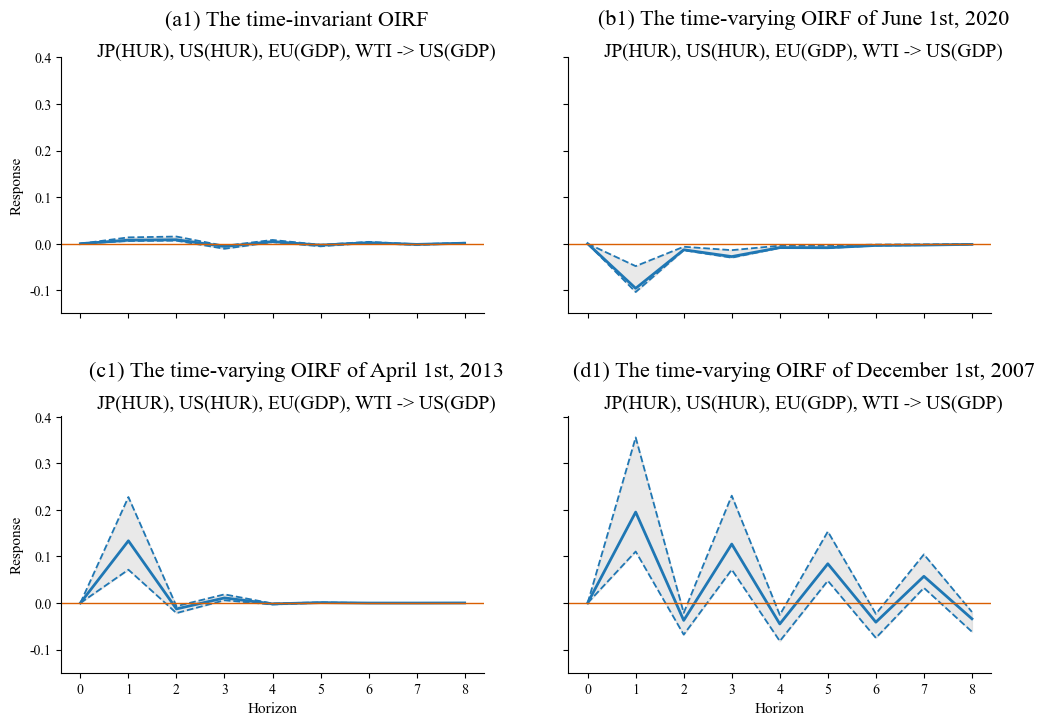

[Saved] C:\github\tvp-gvar-forecasting\figures\Joint_OIRF_Group1.pdf


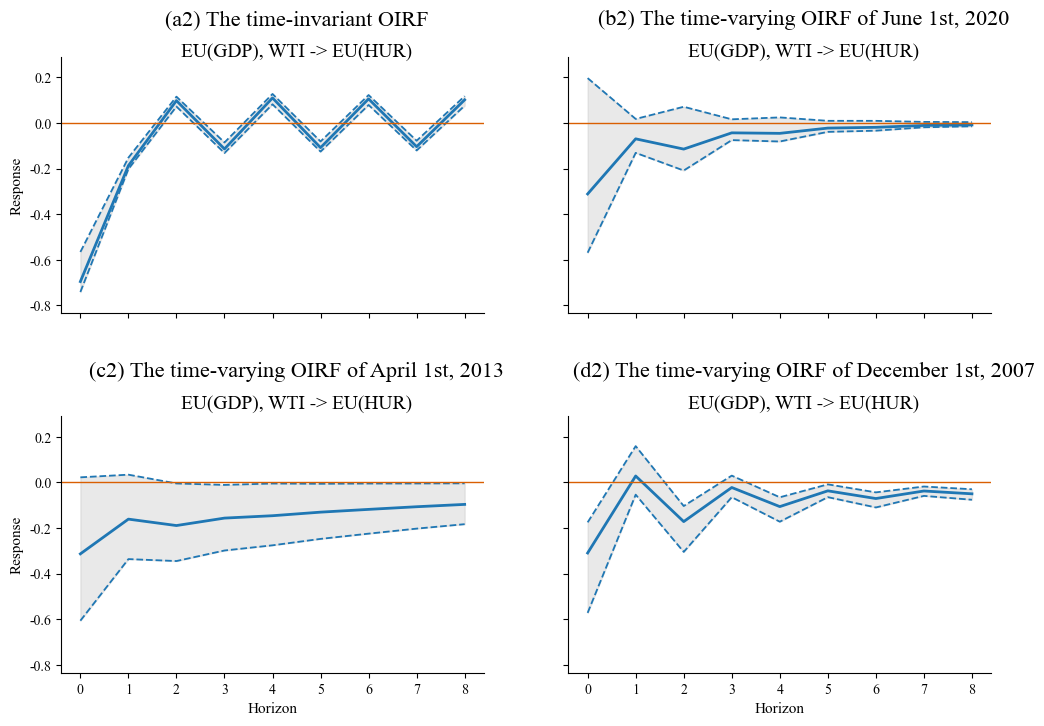

[Saved] C:\github\tvp-gvar-forecasting\figures\Joint_OIRF_Group2.pdf
=== ALL DONE ===


In [3]:
import os
import random
import warnings

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy.linalg import inv, eigvals, cholesky
from statsmodels.tsa.stattools import acf

warnings.filterwarnings("ignore")
np.random.seed(42)
random.seed(42)

PAPER_RC = {
    "font.sans-serif": ["Times New Roman"],
    "axes.unicode_minus": False,
    "font.size": 11,
    "axes.titlesize": 13,
    "figure.titlesize": 15,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "savefig.bbox": "tight",
    "savefig.dpi": 300,
}
mpl.rcParams.update(PAPER_RC)
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42

BLUE = "#1f77b4"
ORANGE = "#d95f02"
GRAY = "#bdbdbd"

LW_MEAN = 2.0
LW_BAND = 1.3
LW_ZERO = 1.0

def fmt_var(name: str) -> str:
    if "_" not in name:
        return name
    a, b = name.split("_", 1)
    return f"{a}({b})"

def fmt_combo(names):
    return ", ".join(fmt_var(n) for n in names)

def choose_block_len(residuals, max_lag: int = 12) -> int:
    acf_vals = acf(residuals, nlags=max_lag)
    for lag in range(1, max_lag + 1):
        if abs(acf_vals[lag]) < 0.2:
            return lag
    return max_lag

def mbb_resample(e_arr, block_len, T_res):
    num_blocks = int(np.ceil(T_res / block_len))
    max_start = T_res - block_len
    blocks = [e_arr[random.randint(0, max_start) : ][:block_len] for _ in range(num_blocks)]
    return np.vstack(blocks)[:T_res]

def load_data(path, split_date: str = "2023-06-01"):
    df = (
        pd.read_excel(path, parse_dates=["Date"])
        .set_index("Date")
        .sort_index()
        .ffill()
    )
    train, test = df.loc[:split_date], df.loc[split_date:]
    return df, train, test

# -------- GVAR structure --------
CPI_IDX, HUR_IDX, GDP_IDX, WTI_IDX = [0, 1, 2], [3, 4, 5], [6, 7, 8], [9]

def make_weights():
    W = np.array(
        [
            [0.0, 0.137, 0.15],
            [0.45, 0.0, 0.85],
            [0.55, 0.863, 0.0],
        ],
        dtype=float,
    )
    np.fill_diagonal(W, 0.0)
    col_sum = W.sum(axis=0, keepdims=True)
    col_sum[col_sum == 0] = 1.0
    W = W / col_sum
    return W

def make_gvar_mask():
    M = np.zeros((10, 10))
    for grp in [CPI_IDX, HUR_IDX, GDP_IDX]:
        for r in grp:
            M[r, grp] = 1
            M[r, WTI_IDX] = 1
    M[9, 9] = 1
    return M

W_E = make_weights()
GVAR_MASK = make_gvar_mask()

# -------- constant GVAR --------
def fit_const_gvar(df_train, var_list, force_stable: bool = True, shrink: float = 0.98):
    X = df_train[var_list].values
    T, n = X.shape

    def foreign(x):
        out = np.zeros_like(x)
        out[CPI_IDX] = W_E @ x[CPI_IDX]
        out[HUR_IDX] = W_E @ x[HUR_IDX]
        out[GDP_IDX] = W_E @ x[GDP_IDX]
        return out

    Z = np.vstack([foreign(X[t - 1]) for t in range(1, T)])
    Y = X[1:]

    b = np.zeros(n)
    F = np.zeros((n, n))

    for i in range(n):
        mask = GVAR_MASK[i].astype(bool)
        Xi = np.column_stack([np.ones(T - 1), Z[:, mask]])
        beta, *_ = np.linalg.lstsq(Xi, Y[:, i], rcond=None)
        b[i] = beta[0]
        F[i, mask] = beta[1:]

    if force_stable:
        rho = np.abs(eigvals(F)).max()
        if rho >= 1:
            F *= shrink / rho

    return b, F

# -------- TVP-GVAR (Kalman) --------
def fit_tvp_gvar(df, Q_b: float = 0.001, Q_f: float = 0.0005):
    var_list = df.columns.tolist()
    X = df.values
    T, n = X.shape
    dim = n + n * n

    theta = np.zeros(dim)
    P = np.eye(dim)
    Q = np.diag(np.r_[np.full(n, Q_b), np.full(n * n, Q_f)])
    R = np.eye(n)

    traj = np.zeros((T, dim))

    def foreign(x):
        out = np.zeros_like(x)
        out[CPI_IDX] = W_E @ x[CPI_IDX]
        out[HUR_IDX] = W_E @ x[HUR_IDX]
        out[GDP_IDX] = W_E @ x[GDP_IDX]
        return out

    for t in range(1, T):
        xp, xn = X[t - 1], X[t]
        z_prev = foreign(xp)

        H = np.zeros((n, dim))
        H[:, :n] = np.eye(n)
        for i in range(n):
            masked = z_prev * GVAR_MASK[i]
            H[i, n + i * n : n + (i + 1) * n] = masked

        theta_pred = theta
        P_pred = P + Q
        v = xn - H @ theta_pred
        S = H @ P_pred @ H.T + R
        K = P_pred @ H.T @ inv(S)
        theta = theta_pred + K @ v
        P = (np.eye(dim) - K @ H) @ P_pred

        b = theta[:n]
        F = theta[n:].reshape(n, n)
        rho = np.abs(eigvals(F)).max()
        if rho >= 1:
            F *= 0.98 / rho
        F *= GVAR_MASK
        theta = np.r_[b, F.flatten()]

        traj[t] = theta

    return traj, var_list

# -------- IRF computation --------
def irf_path(F, shock_vec, horizon: int = 8):
    n = F.shape[0]
    out = np.zeros((horizon + 1, n))
    out[0] = shock_vec
    for h in range(1, horizon + 1):
        out[h] = F @ out[h - 1]
    return out

def combo_vec(chol, names, var_list):
    n = len(var_list)
    v = np.zeros(n)
    for nm in names:
        j = var_list.index(nm)
        col = chol[:, j]
        norm = np.linalg.norm(col)
        if norm > 0:
            v += col / norm
    return v

def joint_irf(
    F, b, errs, var_list,
    shock_combo, target_var,
    horizon: int = 8,
    n_sims: int = 300,
    max_lag: int = 12,
):
    T_res = len(errs)
    n = len(var_list)
    blk = choose_block_len(errs.ravel(), max_lag)

    Sig = errs.T @ errs / max(T_res - 1, 1) + 1e-6 * np.eye(n)
    chol = cholesky(Sig)

    v0 = combo_vec(chol, shock_combo, var_list)
    mu_full = irf_path(F, v0, horizon)

    sims = np.zeros((n_sims, horizon + 1, n))
    for s in range(n_sims):
        e_bs = mbb_resample(errs, blk, T_res)
        Sig_b = e_bs.T @ e_bs / max(T_res - 1, 1) + 1e-6 * np.eye(n)
        chol_b = cholesky(Sig_b)
        v_b = combo_vec(chol_b, shock_combo, var_list)
        sims[s] = irf_path(F, v_b, horizon)

    lo = np.percentile(sims, 2.5, axis=0)
    hi = np.percentile(sims, 97.5, axis=0)

    j = var_list.index(target_var)
    tgrid = np.arange(horizon + 1)
    return tgrid, lo[:, j], hi[:, j], mu_full[:, j]

def plot_joint_irf_grid(
    traj,
    var_list,
    df_train,
    shock_combo,
    target_var,
    pdf_path,
    group_index: int,
    horizon: int = 8,
    n_sims: int = 300,
    max_lag: int = 12,
):
    X = df_train[var_list].values
    n = len(var_list)

    b_c, F_c = fit_const_gvar(df_train, var_list)
    errs_c = np.array([X[t] - (b_c + F_c @ X[t - 1]) for t in range(1, len(X))])

    dates = ["2020-06-01", "2013-04-01", "2007-12-01"]
    idx = [df_train.index.get_loc(d) for d in dates]

    def get_tvp(idx_val):
        b = traj[idx_val, :n]
        F = traj[idx_val, n:].reshape(n, n)
        e = np.array([X[t] - (b + F @ X[t - 1]) for t in range(1, len(X))])
        return b, F, e

    b20, F20, e20 = get_tvp(idx[0])
    b13, F13, e13 = get_tvp(idx[1])
    b07, F07, e07 = get_tvp(idx[2])

    t_c, lo_c, hi_c, mu_c = joint_irf(F_c, b_c, errs_c, var_list, shock_combo, target_var, horizon, n_sims, max_lag)
    t20, lo20, hi20, mu20 = joint_irf(F20, b20, e20, var_list, shock_combo, target_var, horizon, n_sims, max_lag)
    t13, lo13, hi13, mu13 = joint_irf(F13, b13, e13, var_list, shock_combo, target_var, horizon, n_sims, max_lag)
    t07, lo07, hi07, mu07 = joint_irf(F07, b07, e07, var_list, shock_combo, target_var, horizon, n_sims, max_lag)

    Y = np.concatenate([lo_c, hi_c, lo20, hi20, lo13, hi13, lo07, hi07])
    pad = 0.10 * (Y.max() - Y.min())
    y_lim = (Y.min() - pad, Y.max() + pad)

    fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
    axes = axes.flatten()

    def draw(ax, t, lo, hi, mu):
        ax.fill_between(t, lo, hi, color=GRAY, alpha=0.33)
        ax.plot(t, lo, "--", color=BLUE, lw=LW_BAND)
        ax.plot(t, hi, "--", color=BLUE, lw=LW_BAND)
        ax.plot(t, mu, "-", color=BLUE, lw=LW_MEAN)
        ax.axhline(0, color=ORANGE, lw=LW_ZERO)
        ax.set_ylim(*y_lim)

    draw(axes[0], t_c, lo_c, hi_c, mu_c)
    draw(axes[1], t20, lo20, hi20, mu20)
    draw(axes[2], t13, lo13, hi13, mu13)
    draw(axes[3], t07, lo07, hi07, mu07)

    for ax in axes[2:4]:
        ax.set_xlabel("Horizon")
    for ax in (axes[0], axes[2]):
        ax.set_ylabel("Response")

    centers = []
    for ax in axes:
        pos = ax.get_position()
        xc = pos.x0 + pos.width / 2
        xc += 0.02
        centers.append(xc)

    labels = {1: ["(a1)", "(b1)", "(c1)", "(d1)"], 2: ["(a2)", "(b2)", "(c2)", "(d2)"]}[group_index]
    main_titles = [
        "The time-invariant OIRF",
        "The time-varying OIRF of June 1st, 2020",
        "The time-varying OIRF of April 1st, 2013",
        "The time-varying OIRF of December 1st, 2007",
    ]
    combo = f"{fmt_combo(shock_combo)} -> {fmt_var(target_var)}"

    Y1, Y2, Y3, Y4 = 0.92, 0.88, 0.48, 0.44

    fig.text(centers[0], Y1, f"{labels[0]} {main_titles[0]}", ha="center", fontsize=16)
    fig.text(centers[1], Y1, f"{labels[1]} {main_titles[1]}", ha="center", fontsize=16)
    fig.text(centers[0], Y2, combo, ha="center", fontsize=14)
    fig.text(centers[1], Y2, combo, ha="center", fontsize=14)

    fig.text(centers[2], Y3, f"{labels[2]} {main_titles[2]}", ha="center", fontsize=16)
    fig.text(centers[3], Y3, f"{labels[3]} {main_titles[3]}", ha="center", fontsize=16)
    fig.text(centers[2], Y4, combo, ha="center", fontsize=14)
    fig.text(centers[3], Y4, combo, ha="center", fontsize=14)

    plt.subplots_adjust(hspace=0.40)

    fig.savefig(pdf_path, dpi=300)
    plt.show()
    print(f"[Saved] {pdf_path}")


def main():
    out_dir = "../results"
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
        
    file_path = "../data/macro_panel.xlsx"

    df, train, _ = load_data(file_path, split_date="2024-01-01")
    traj, var_list = fit_tvp_gvar(train)

    shocks_1 = ["JP_HUR", "US_HUR", "EU_GDP", "WTI"]
    target_1 = "US_GDP"
    pdf_A = os.path.join(out_dir, "Joint_OIRF_Group1.pdf")
    plot_joint_irf_grid(traj, var_list, train, shocks_1, target_1, pdf_A, group_index=1)

    shocks_2 = ["EU_GDP", "WTI"]
    target_2 = "EU_HUR"
    pdf_B = os.path.join(out_dir, "Joint_OIRF_Group2.pdf")
    plot_joint_irf_grid(traj, var_list, train, shocks_2, target_2, pdf_B, group_index=2)

    print("=== ALL DONE ===")


if __name__ == "__main__":
    main()